In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv(r'C:\Users\nivetta.t.lv\Downloads\customer_shopping_data.csv')

In [3]:
df.head()

,invoice_no,customer_id,gender,age,category,quantity,price,payment_method,invoice_date,shopping_mall
0,I138884,C241288,Female,28,Clothing,5,1500.40,Credit Card,5/8/2022,Kanyon
1,I317333,C111565,Male,21,Shoes,3,1800.51,Debit Card,12/12/2021,Forum Istanbul
2,I127801,C266599,Male,20,Clothing,1,300.08,Cash,9/11/2021,Metrocity
3,I173702,C988172,Female,66,Shoes,5,3000.85,Credit Card,16/05/2021,Metropol AVM
4,I337046,C189076,Female,53,Books,4,60.60,Cash,24/10/2021,Kanyon


In [4]:
df.groupby("invoice_no").size()
# So, each invoice corresponds to exactly one row, not multiple line items.

invoice_no
I100008    1
I100014    1
I100015    1
I100024    1
I100027    1
          ..
I999956    1
I999959    1
I999972    1
I999973    1
I999994    1
Length: 99457, dtype: int64

In [5]:
df['invoice_no'].nunique(), len(df)


(99457, 99457)

In [6]:
# Data Shape

In [7]:
print("Initial shape:", df.shape)
print("Columns:", df.columns.tolist())

Initial shape: (99457, 10)
Columns: ['invoice_no', 'customer_id', 'gender', 'age', 'category', 'quantity', 'price', 'payment_method', 'invoice_date', 'shopping_mall']


In [8]:
# --- figuring out which date format works the best-
def try_parse_date(s, dayfirst):
    return pd.to_datetime(s, errors='coerce', dayfirst=dayfirst)

d1 = try_parse_date(df['invoice_date'], dayfirst=False)  # assume month/day/year
d2 = try_parse_date(df['invoice_date'], dayfirst=True)   # assume day/month/year

# Count how many parsing failures (NaT = Not a Time) under each option
count_nat_d1 = d1.isna().sum()
count_nat_d2 = d2.isna().sum()

# Choose whichever gives fewer failures
if count_nat_d2 < count_nat_d1:
    df['invoice_date'] = d2
    print("Using dayfirst=True for invoice_date parsing.")
else:
    df['invoice_date'] = d1
    print("Using dayfirst=False for invoice_date parsing.")


Using dayfirst=True for invoice_date parsing.


In [9]:
print("\nData info:")

print(df.info())


Data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99457 entries, 0 to 99456
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   invoice_no      99457 non-null  object        
 1   customer_id     99457 non-null  object        
 2   gender          99457 non-null  object        
 3   age             99457 non-null  int64         
 4   category        99457 non-null  object        
 5   quantity        99457 non-null  int64         
 6   price           99457 non-null  float64       
 7   payment_method  99457 non-null  object        
 8   invoice_date    99457 non-null  datetime64[ns]
 9   shopping_mall   99457 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(6)
memory usage: 7.6+ MB
None


In [10]:
# --- missingness summary ---
# already non-null cnt is calc above, but this is null count, how many values are null
missing_counts = df.isnull().sum().sort_values(ascending=False)
missing_pct = (df.isnull().mean()*100).sort_values(ascending=False)
print("\nTop missing columns:\n", pd.concat([missing_counts, missing_pct], axis=1).head(20).rename(columns={0:'missing_count',1:'missing_pct'}))


Top missing columns:
                 missing_count  missing_pct
invoice_no                  0          0.0
customer_id                 0          0.0
gender                      0          0.0
age                         0          0.0
category                    0          0.0
quantity                    0          0.0
price                       0          0.0
payment_method              0          0.0
invoice_date                0          0.0
shopping_mall               0          0.0


In [11]:
# --- dedupe by invoice_no 
if 'invoice_no' in df.columns:
    dup_by_invoice = df.duplicated(subset='invoice_no').sum()
    print("Duplicate invoice_no rows:", dup_by_invoice)
else:
    print("No invoice_no column to dedupe on; checking full-duplicate rows:", df.duplicated().sum())

Duplicate invoice_no rows: 0


In [12]:
# for a static data set this is redundant as we already run the code above, but when we get fresh data on a daily basis then this is something that will help

df['invoice_no'].nunique(), len(df)   # unique invoices vs rows
df.groupby('invoice_no').size().sort_values(ascending=False).head()


invoice_no
I999994    1
I999621    1
I999572    1
I999562    1
I999457    1
dtype: int64

In [13]:
full_dups = df.duplicated().sum()
invoice_dups = df.duplicated(subset=['invoice_no','product'] if 'product' in df.columns else ['invoice_no','quantity','price']).sum()
full_dups, invoice_dups


(np.int64(0), np.int64(0))

In [14]:
print(df['age'].describe())

count    99457.000000
mean        43.427089
std         14.990054
min         18.000000
25%         30.000000
50%         43.000000
75%         56.000000
max         69.000000
Name: age, dtype: float64


In [15]:
# --- Clean payment_method, but keep both detailed & grouped versions

# Step 1: Clean original values
df['payment_method_raw'] = (
    df['payment_method']
    .astype(str)
    .str.strip()
    .str.lower()
)

# Step 2: Group into broad categories
payment_map = {
    'credit card': 'card',
    'debit card': 'card',
    'card': 'card',
    'cash': 'cash',
    'upi': 'upi'
}

df['payment_method'] = df['payment_method_raw'].map(lambda x: payment_map.get(x, x))

# Step 3: Make names pretty for raw column
df['payment_method_raw'] = df['payment_method_raw'].str.title()

# Quick check
print("Grouped Payment Methods:")
print(df['payment_method'].value_counts(normalize=True))

print("\nDetailed Payment Methods:")
print(df['payment_method_raw'].value_counts(normalize=True))


Grouped Payment Methods:
payment_method
card    0.553103
cash    0.446897
Name: proportion, dtype: float64

Detailed Payment Methods:
payment_method_raw
Cash           0.446897
Credit Card    0.351217
Debit Card     0.201886
Name: proportion, dtype: float64


In [16]:
# Create net_sales (line item total)
df['net_sales'] = df['quantity'] * df['price']

# invoice_agg = df.groupby('invoice_no').agg({
#     'customer_id':'first','invoice_date':'first','net_sales':'sum','quantity':'sum','payment_method':'first'
# }).rename(columns={'net_sales':'invoice_total'}).reset_index()
# invoice_agg['aov'] = invoice_agg['invoice_total'] / invoice_agg['quantity'].replace(0,1)



In [17]:
df.to_parquet(r'C:\Users\nivetta.t.lv\Documents\mlops\sales_clean_final.parquet', index=False)
invoice_agg.to_parquet(r'C:\Users\nivetta.t.lv\Documents\mlops\invoice_agg.parquet', index=False)

print("saved cleaned files")

NameError: name 'invoice_agg' is not defined

In [18]:
df.head()

,invoice_no,customer_id,gender,age,category,quantity,price,payment_method,invoice_date,shopping_mall,payment_method_raw,net_sales
0,I138884,C241288,Female,28,Clothing,5,1500.40,card,2022-08-05,Kanyon,Credit Card,7502.00
1,I317333,C111565,Male,21,Shoes,3,1800.51,card,2021-12-12,Forum Istanbul,Debit Card,5401.53
2,I127801,C266599,Male,20,Clothing,1,300.08,cash,2021-11-09,Metrocity,Cash,300.08
3,I173702,C988172,Female,66,Shoes,5,3000.85,card,2021-05-16,Metropol AVM,Credit Card,15004.25
4,I337046,C189076,Female,53,Books,4,60.60,cash,2021-10-24,Kanyon,Cash,242.40


In [19]:

# Mall-level aggregation
#Groups all rows in the dataset by each mall.
#This allows you to calculate totals, averages, and other metrics per mall.
mall_perf = df.groupby('shopping_mall').agg(
    total_sales=('net_sales','sum'),
    total_qty=('quantity','sum'),
    unique_customers=('customer_id','nunique'),
    num_invoices=('invoice_no','nunique')
).reset_index()

# Average order value per mall
mall_perf['avg_order_value'] = mall_perf['total_sales'] / mall_perf['num_invoices']

print(mall_perf)

       shopping_mall  total_sales  total_qty  unique_customers  num_invoices  \
0        Cevahir AVM  12645138.20      14949              4991          4991   
1  Emaar Square Mall  12406100.29      14501              4811          4811   
2     Forum Istanbul  12303921.24      14852              4947          4947   
3       Istinye Park  24618827.68      29465              9781          9781   
4             Kanyon  50554231.10      59457             19823         19823   
5   Mall of Istanbul  50872481.68      60114             19943         19943   
6          Metrocity  37302787.33      44894             15011         15011   
7       Metropol AVM  25379913.19      30530             10161         10161   
8     Viaport Outlet  12521339.72      14716              4914          4914   
9       Zorlu Center  12901053.82      15234              5075          5075   

   avg_order_value  
0      2533.588099  
1      2578.694718  
2      2487.148017  
3      2517.005181  
4      2550.28

C:\Users\nivetta.t.lv\AppData\Local\Temp\ipykernel_28800\2387114664.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=mall_perf.sort_values('total_sales',ascending=False),


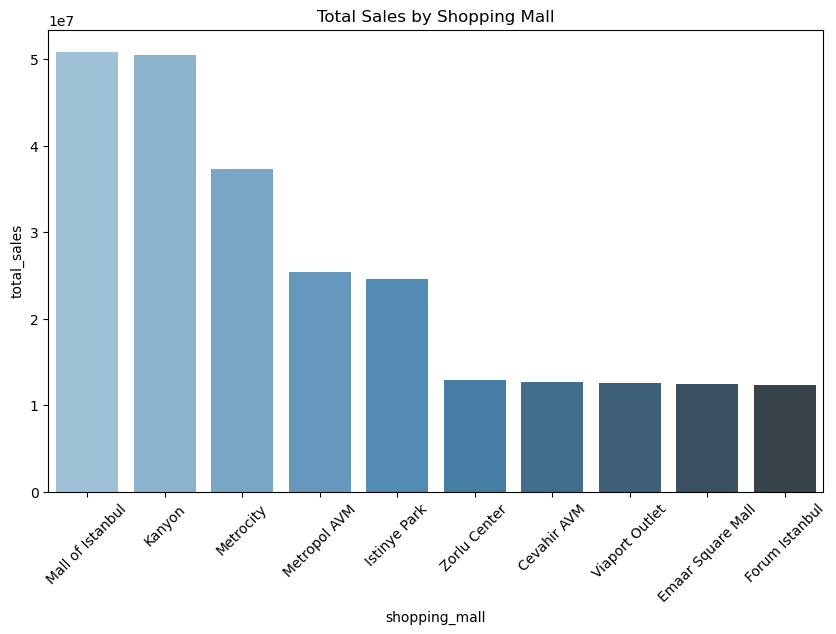

In [20]:
# --- Visualization ---
plt.figure(figsize=(10,6))
sns.barplot(data=mall_perf.sort_values('total_sales',ascending=False),
            x='shopping_mall', y='total_sales', palette='Blues_d')
plt.xticks(rotation=45)
plt.title("Total Sales by Shopping Mall")
plt.show()

In [21]:
# --- Customer-Level Analysis: Top Customers ---

# 1. Aggregate customer metrics
customer_summary = (
    df.groupby('customer_id')
    .agg(
        total_spent=('net_sales', 'sum'),
        total_qty=('quantity', 'sum'),
        num_invoices=('invoice_no', 'nunique')
    )
    .reset_index()
)

# 2. Calculate average order value (AOV)
customer_summary['avg_order_value'] = (
    customer_summary['total_spent'] / customer_summary['num_invoices']
)
print(customer_summary.sort_values('total_spent', ascending=False).head(10))



      customer_id  total_spent  total_qty  num_invoices  avg_order_value
48763     C255975      26250.0          5             1          26250.0
37318     C219246      26250.0          5             1          26250.0
80025     C471560      26250.0          5             1          26250.0
80267     C477683      26250.0          5             1          26250.0
80233     C476770      26250.0          5             1          26250.0
93        C100322      26250.0          5             1          26250.0
23811     C176113      26250.0          5             1          26250.0
55134     C276116      26250.0          5             1          26250.0
80057     C472297      26250.0          5             1          26250.0
19492     C162292      26250.0          5             1          26250.0


C:\Users\nivetta.t.lv\AppData\Local\Temp\ipykernel_28800\834258396.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


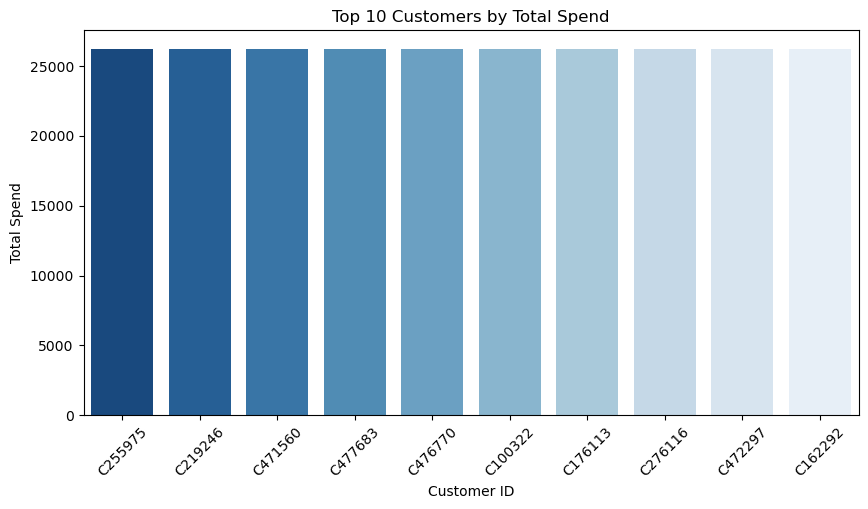

In [22]:
top_10_customers = (
    customer_summary.sort_values('total_spent', ascending=False)
    .head(10)
)
plt.figure(figsize=(10,5))
sns.barplot(
    data=top_10_customers,
    x='customer_id',
    y='total_spent',
    palette='Blues_r'
)
plt.xticks(rotation=45)
plt.title("Top 10 Customers by Total Spend")
plt.xlabel("Customer ID")
plt.ylabel("Total Spend")
plt.show()

In [23]:
# 3. Segment: Top 10% customers by spend
spend_threshold = customer_summary['total_spent'].quantile(0.90)
customer_summary['segment'] = np.where(
    customer_summary['total_spent'] >= spend_threshold,
    'Top 10%',
    'Other'
)

# 4. Contribution of top vs. other customers
segment_contribution = (
    customer_summary.groupby('segment')['total_spent'].sum()
)
segment_contribution_pct = (
    segment_contribution / segment_contribution.sum() * 100
)
print("Revenue Contribution by Segment (%):\n", segment_contribution_pct)

Revenue Contribution by Segment (%):
 segment
Other      38.64466
Top 10%    61.35534
Name: total_spent, dtype: float64


C:\Users\nivetta.t.lv\AppData\Local\Temp\ipykernel_28800\1528552159.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


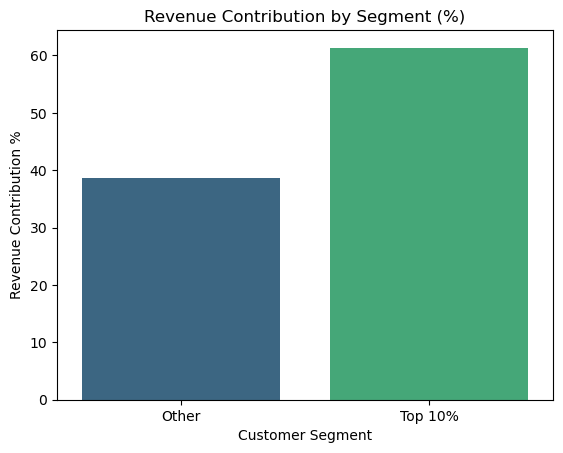

In [24]:
sns.barplot(
    x=segment_contribution_pct.index,
    y=segment_contribution_pct.values,
    palette="viridis"
)
plt.title("Revenue Contribution by Segment (%)")
plt.ylabel("Revenue Contribution %")
plt.xlabel("Customer Segment")
plt.show()


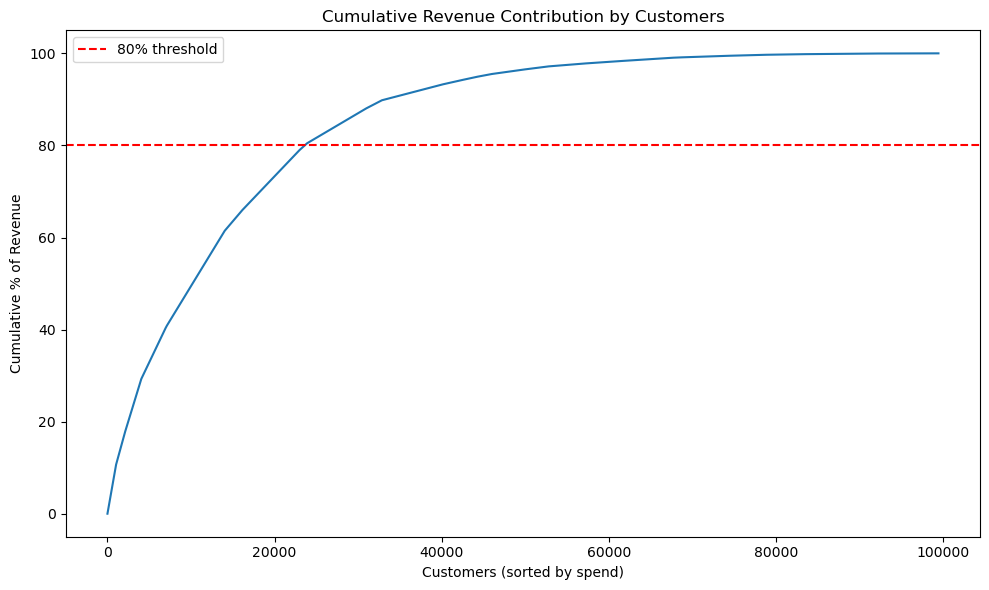

In [25]:
# 6. Visualization: Cumulative Revenue Contribution
customer_sorted = (
    customer_summary.sort_values('total_spent', ascending=False)
    .reset_index(drop=True)
)
customer_sorted['cumulative_pct'] = (
    customer_sorted['total_spent'].cumsum()
    / customer_sorted['total_spent'].sum() * 100
)

plt.figure(figsize=(10, 6))
sns.lineplot(
    data=customer_sorted,
    x=customer_sorted.index,
    y='cumulative_pct'
)
plt.axhline(80, color='red', linestyle='--', label="80% threshold")
plt.title("Cumulative Revenue Contribution by Customers")
plt.xlabel("Customers (sorted by spend)")
plt.ylabel("Cumulative % of Revenue")
plt.legend()
plt.tight_layout()
plt.show()


In [26]:
# --- Daily sales performance ---
daily_sales = (
    df.groupby('invoice_date')
    .agg(
        total_sales=('net_sales', 'sum'),
        total_qty=('quantity', 'sum'),
        num_invoices=('invoice_no', 'nunique')
    )
    .reset_index()
)

print(daily_sales.head())


  invoice_date  total_sales  total_qty  num_invoices
0   2021-01-01    271192.66        333           105
1   2021-01-02    303659.14        387           134
2   2021-01-03    375794.99        405           137
3   2021-01-04    284512.26        379           119
4   2021-01-05    308395.08        374           120


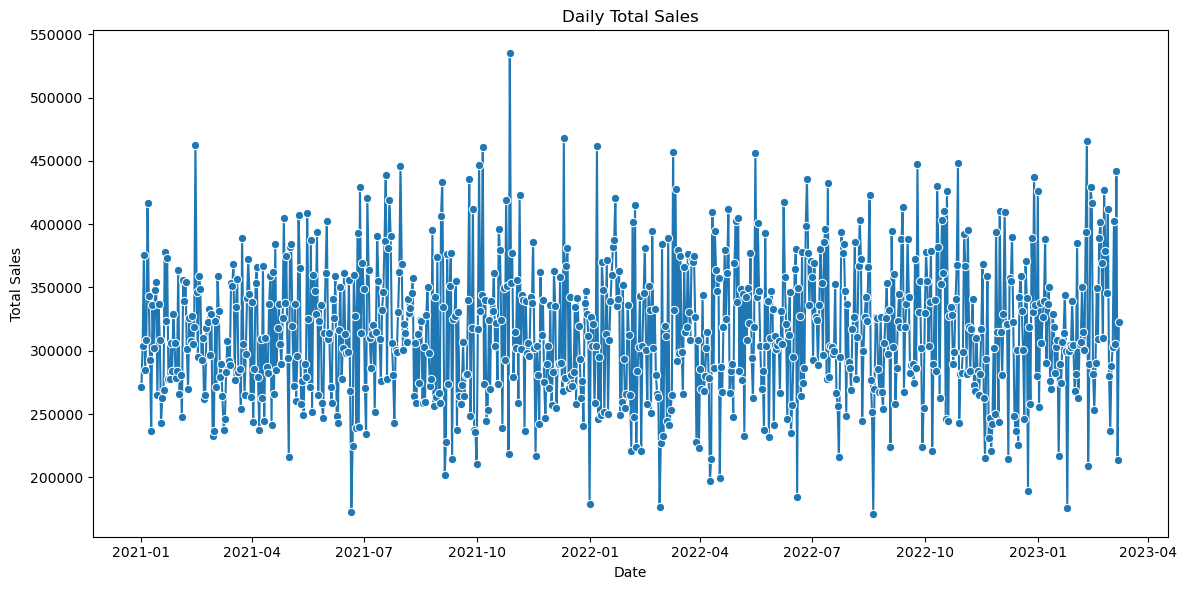

In [27]:
plt.figure(figsize=(12,6))
sns.lineplot(
    data=daily_sales,
    x='invoice_date',
    y='total_sales',
    marker="o"
)
plt.title("Daily Total Sales")
plt.xlabel("Date")
plt.ylabel("Total Sales")
plt.tight_layout()
plt.show()
#Total Sales per Day → “How much money are we making each day?”

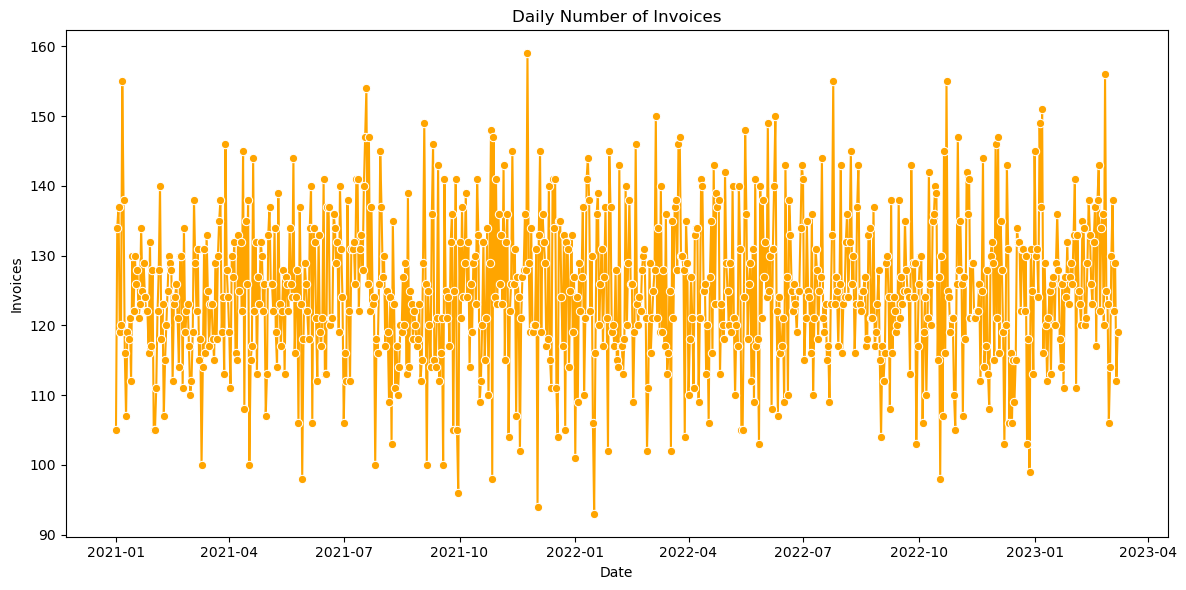

In [28]:
plt.figure(figsize=(12,6))
sns.lineplot(
    data=daily_sales,
    x='invoice_date',
    y='num_invoices',
    marker="o",
    color='orange'
)
plt.title("Daily Number of Invoices")
plt.xlabel("Date")
plt.ylabel("Invoices")
plt.tight_layout()
plt.show()
#Number of Invoices per Day → “How many customers/transactions are happening each day?”

In [29]:
# --- Store (Mall) level daily performance ---
store_daily_sales = (
    df.groupby(['shopping_mall', 'invoice_date'])
    .agg(
        total_sales=('net_sales', 'sum'),
        total_qty=('quantity', 'sum'),
        num_invoices=('invoice_no', 'nunique')
    )
    .reset_index()
)

print(store_daily_sales.head())




  shopping_mall invoice_date  total_sales  total_qty  num_invoices
0   Cevahir AVM   2021-01-01      3332.96         11             4
1   Cevahir AVM   2021-01-02      8001.47         25             7
2   Cevahir AVM   2021-01-03     22065.69         24             8
3   Cevahir AVM   2021-01-04     15943.38         19             5
4   Cevahir AVM   2021-01-05      5984.41         17             6


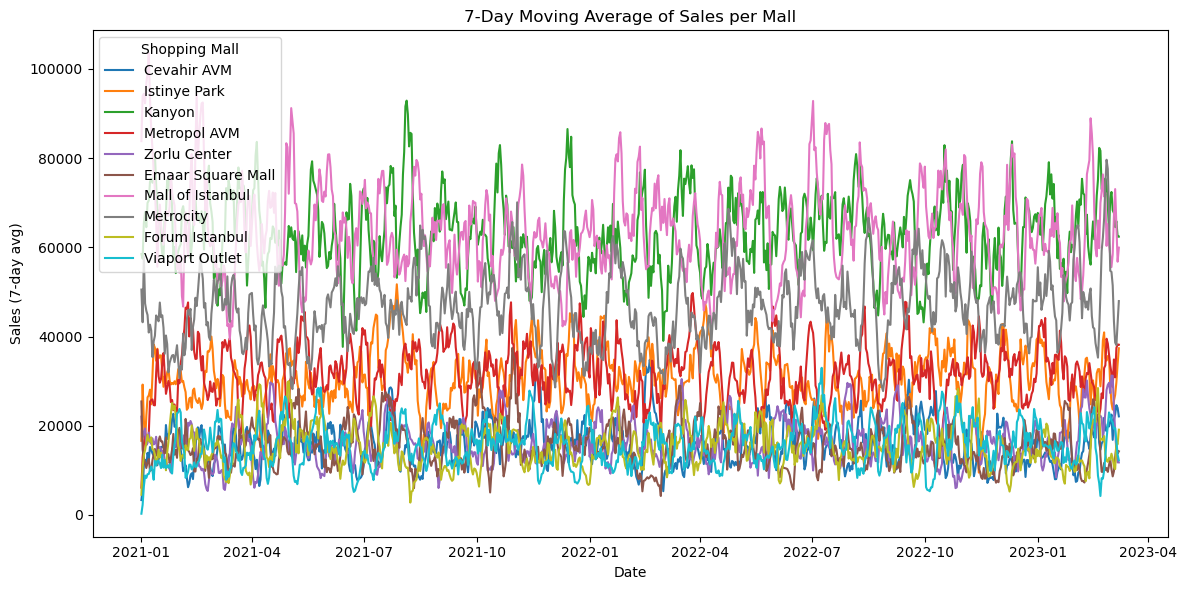

In [30]:
store_daily_sales['invoice_date'] = pd.to_datetime(store_daily_sales['invoice_date'])
store_daily_sales = store_daily_sales.sort_values('invoice_date')

# Example: 7-day rolling avg per mall
store_daily_sales['sales_ma7'] = (
    store_daily_sales.groupby('shopping_mall')['total_sales']
    .transform(lambda x: x.rolling(7, min_periods=1).mean())
)

plt.figure(figsize=(12,6))
sns.lineplot(
    data=store_daily_sales,
    x='invoice_date',
    y='sales_ma7',
    hue='shopping_mall'
)
plt.title("7-Day Moving Average of Sales per Mall")
plt.xlabel("Date")
plt.ylabel("Sales (7-day avg)")
plt.legend(title="Shopping Mall")
plt.tight_layout()
plt.show()


In [31]:
# seasonality analysis
df['invoice_date'] = pd.to_datetime(df['invoice_date'], errors='coerce')


In [32]:
# Extract month and quarter for grouping
df['year_month'] = df['invoice_date'].dt.to_period('M')
df['year_quarter'] = df['invoice_date'].dt.to_period('Q')


In [33]:
# Monthly sales
monthly_sales = (
    df.groupby('year_month')
    .agg(total_sales=('net_sales', 'sum'),
         total_qty=('quantity', 'sum'),
         num_invoices=('invoice_no', 'nunique'))
    .reset_index()
)

# Quarterly sales
quarterly_sales = (
    df.groupby('year_quarter')
    .agg(total_sales=('net_sales', 'sum'),
         total_qty=('quantity', 'sum'),
         num_invoices=('invoice_no', 'nunique'))
    .reset_index()
)


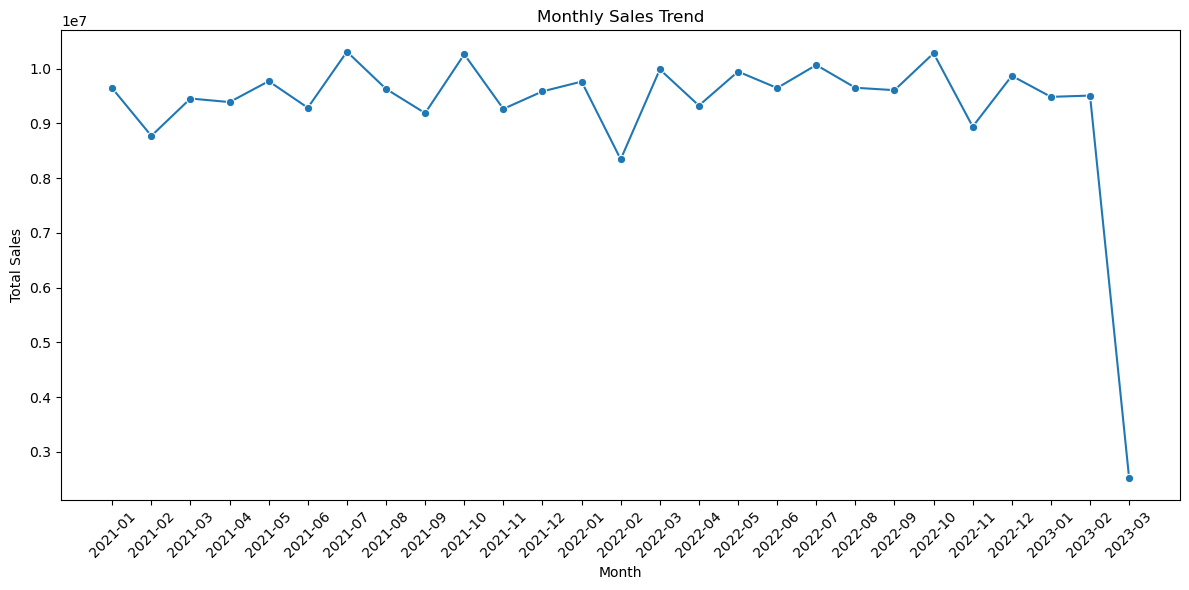

In [34]:
# Convert year_month to string for plotting
monthly_sales['year_month'] = monthly_sales['year_month'].astype(str)

plt.figure(figsize=(12,6))
sns.lineplot(data=monthly_sales, x='year_month', y='total_sales', marker='o')
plt.xticks(rotation=45)
plt.title("Monthly Sales Trend")
plt.xlabel("Month")
plt.ylabel("Total Sales")
plt.tight_layout()
plt.show()


C:\Users\nivetta.t.lv\AppData\Local\Temp\ipykernel_28800\3692189116.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=quarterly_sales, x='year_quarter', y='total_sales', palette='viridis')


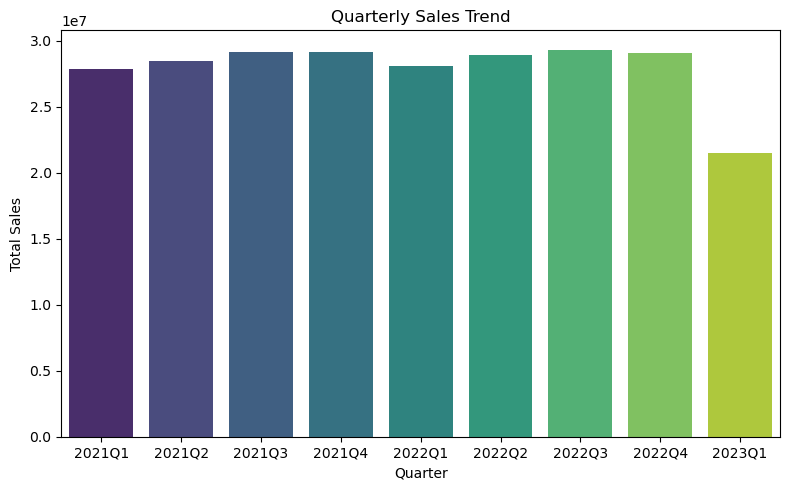

In [35]:
# Convert year_quarter to string for plotting
quarterly_sales['year_quarter'] = quarterly_sales['year_quarter'].astype(str)

plt.figure(figsize=(8,5))
sns.barplot(data=quarterly_sales, x='year_quarter', y='total_sales', palette='viridis')
plt.title("Quarterly Sales Trend")
plt.xlabel("Quarter")
plt.ylabel("Total Sales")
plt.tight_layout()
plt.show()


  payment_method  percentage
0           card   55.310335
1           cash   44.689665


C:\Users\nivetta.t.lv\AppData\Local\Temp\ipykernel_28800\3692738835.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


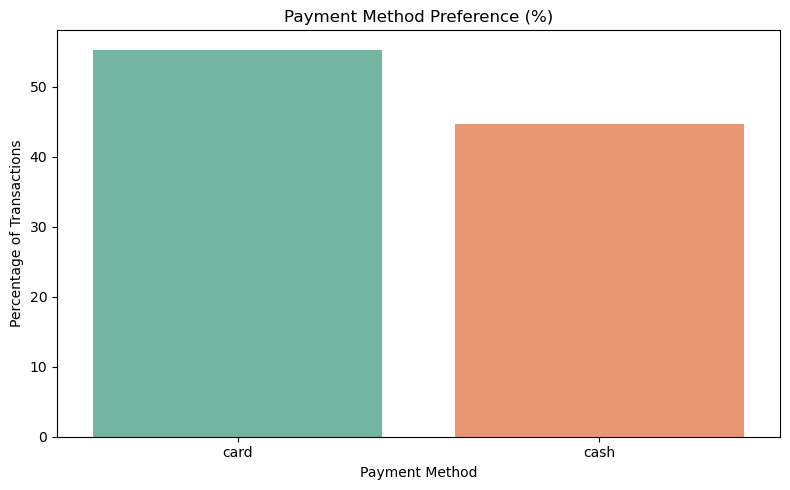

In [36]:
# --- Step 6: Payment Method Preference (Bar Chart Only) ---
payment_dist = (
    df['payment_method']
    .value_counts(normalize=True) * 100
).reset_index()

payment_dist.columns = ['payment_method', 'percentage']

print(payment_dist)

# --- Visualization: Bar Chart ---
plt.figure(figsize=(8,5))
sns.barplot(
    data=payment_dist,
    x='payment_method',
    y='percentage',
    palette='Set2'
)
plt.title("Payment Method Preference (%)")
plt.xlabel("Payment Method")
plt.ylabel("Percentage of Transactions")
plt.tight_layout()
plt.show()


In [37]:
# RFM
import datetime as dt

# Reference date = last transaction date + 1 day
reference_date = df['invoice_date'].max() + dt.timedelta(days=1)

# Recency per customer
recency_df = (
    df.groupby('customer_id')['invoice_date']
    .max()
    .reset_index()
)
recency_df['recency'] = (reference_date - recency_df['invoice_date']).dt.days


In [38]:
# Frequency = number of unique invoices per customer.
frequency_df = (
    df.groupby('customer_id')['invoice_no']
    .nunique()
    .reset_index()
    .rename(columns={'invoice_no': 'frequency'})
)


In [39]:
# Monetary = total money spent by customer.
monetary_df = (
    df.groupby('customer_id')['net_sales']
    .sum()
    .reset_index()
    .rename(columns={'net_sales': 'monetary'})
)


In [40]:
# Merge R, F, M
rfm = recency_df.merge(frequency_df, on='customer_id')
rfm = rfm.merge(monetary_df, on='customer_id')


In [41]:
Assign R, F, M Scores

Use quantiles (e.g., qcut into 5 bins).

Recency is inverse (lower recency = better, so scoring is flipped).

SyntaxError: invalid syntax (2404230830.py, line 1)

In [42]:
rfm['R_score'] = pd.qcut(rfm['recency'], 5, labels=[5,4,3,2,1])
rfm['F_score'] = pd.qcut(rfm['frequency'].rank(method='first'), 5, labels=[1,2,3,4,5])
rfm['M_score'] = pd.qcut(rfm['monetary'], 5, labels=[1,2,3,4,5])


In [43]:
rfm['RFM_Segment'] = (
    rfm['R_score'].astype(str) +
    rfm['F_score'].astype(str) +
    rfm['M_score'].astype(str)
)

rfm['RFM_Score'] = (
    rfm['R_score'].astype(int) +
    rfm['F_score'].astype(int) +
    rfm['M_score'].astype(int)
)


In [44]:
def segment_customer(score):
    if score >= 12:
        return 'Champions'
    elif score >= 9:
        return 'Loyal'
    elif score >= 6:
        return 'At Risk'
    else:
        return 'Lost'

rfm['Segment'] = rfm['RFM_Score'].apply(segment_customer)


In [45]:
rfm.head()

,customer_id,invoice_date,recency,frequency,monetary,R_score,F_score,M_score,RFM_Segment,RFM_Score,Segment
0,C100004,2021-11-26,468,1,7502.00,3,1,5,315,9,Loyal
1,C100005,2023-03-03,6,1,2400.68,5,1,4,514,10,Loyal
2,C100006,2022-12-01,98,1,322.56,5,1,3,513,9,Loyal
3,C100012,2021-08-15,571,1,130.75,2,1,2,212,5,Lost
4,C100019,2021-07-25,592,1,35.84,2,1,1,211,4,Lost


In [46]:
print(rfm['Segment'].value_counts())


Segment
Loyal        41208
At Risk      35004
Champions    15231
Lost          8014
Name: count, dtype: int64


In [47]:
segment_summary = rfm.groupby('Segment').agg(
    customers=('customer_id', 'count'),
    total_revenue=('monetary', 'sum'),
    avg_recency=('recency', 'mean'),
    avg_frequency=('frequency', 'mean')
).reset_index()

print(segment_summary)


     Segment  customers  total_revenue  avg_recency  avg_frequency
0    At Risk      35004   4.397160e+07   494.191321            1.0
1  Champions      15231   8.515687e+07   194.831134            1.0
2       Lost       8014   1.188936e+06   636.294734            1.0
3      Loyal      41208   1.211884e+08   344.761697            1.0


C:\Users\nivetta.t.lv\AppData\Local\Temp\ipykernel_28800\669552198.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=rfm, x='Segment', order=rfm['Segment'].value_counts().index, palette="Set2")


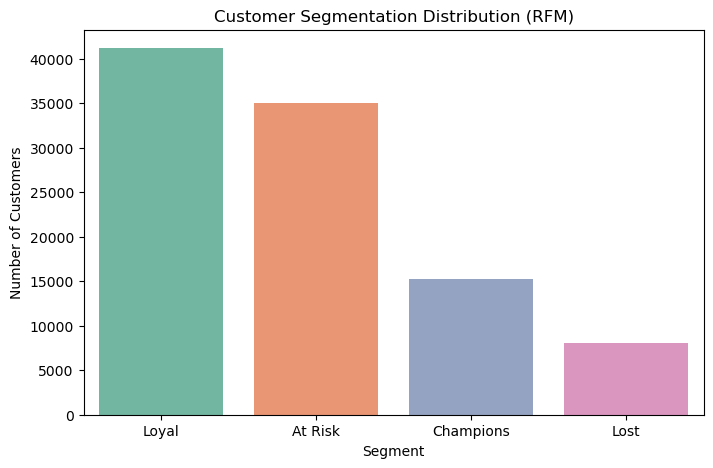

In [48]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
sns.countplot(data=rfm, x='Segment', order=rfm['Segment'].value_counts().index, palette="Set2")
plt.title("Customer Segmentation Distribution (RFM)")
plt.ylabel("Number of Customers")
plt.show()


In [49]:
# Repeat Customer vs. One-time Analysis.
# Count number of invoices per customer
customer_orders = df.groupby('customer_id')['invoice_no'].nunique().reset_index()
customer_orders.rename(columns={'invoice_no': 'num_invoices'}, inplace=True)

# Classify
customer_orders['customer_type'] = np.where(customer_orders['num_invoices'] > 1,
                                            'Repeat Customer', 'One-time Customer')

print(customer_orders['customer_type'].value_counts())


customer_type
One-time Customer    99457
Name: count, dtype: int64


In [50]:
# Merge with spend
customer_spend = df.groupby('customer_id')['net_sales'].sum().reset_index()
customer_orders = customer_orders.merge(customer_spend, on='customer_id', how='left')

# Aggregate contribution
repeat_vs_one = customer_orders.groupby('customer_type')['net_sales'].sum().reset_index()
print(repeat_vs_one)


       customer_type     net_sales
0  One-time Customer  2.515058e+08


C:\Users\nivetta.t.lv\AppData\Local\Temp\ipykernel_28800\1469072024.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=repeat_vs_one, x='customer_type', y='net_sales', palette='coolwarm')


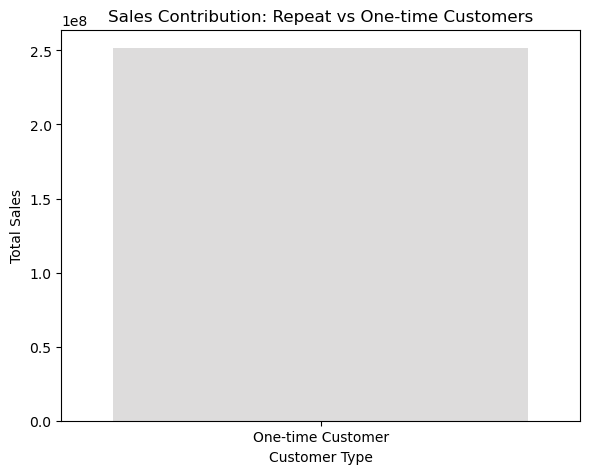

In [51]:
plt.figure(figsize=(6,5))
sns.barplot(data=repeat_vs_one, x='customer_type', y='net_sales', palette='coolwarm')
plt.title("Sales Contribution: Repeat vs One-time Customers")
plt.ylabel("Total Sales")
plt.xlabel("Customer Type")
plt.tight_layout()
plt.show()


In [52]:
print(df.groupby('customer_id')['invoice_no'].nunique().value_counts())


invoice_no
1    99457
Name: count, dtype: int64


In [53]:
99,457 customers exist in the dataset.

Every single one of them has only 1 invoice.

Meaning: there are no repeat customers in the dataset.
"In the provided dataset, all customers are one-time purchasers, hence repeat-customer analysis isn’t applicable."

SyntaxError: invalid syntax (4053805571.py, line 1)


Category Performance Summary:
           category   total_sales  total_qty  num_customers  num_invoices  \
1         Clothing  1.139968e+08     103558          34487         34487   
4            Shoes  6.655345e+07      30217          10034         10034   
6       Technology  5.786235e+07      15021           4996          4996   
2        Cosmetics  6.792863e+06      45465          15097         15097   
7             Toys  3.980426e+06      30321          10087         10087   
3  Food & Beverage  8.495351e+05      44277          14776         14776   
0            Books  8.345529e+05      14982           4981          4981   
5         Souvenir  6.358247e+05      14871           4999          4999   

   avg_order_value  
1      3305.500364  
4      6632.793649  
6     11581.735388  
2       449.947864  
7       394.609521  
3        57.494251  
0       167.547260  
5       127.190368  


C:\Users\nivetta.t.lv\AppData\Local\Temp\ipykernel_28800\3462533004.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


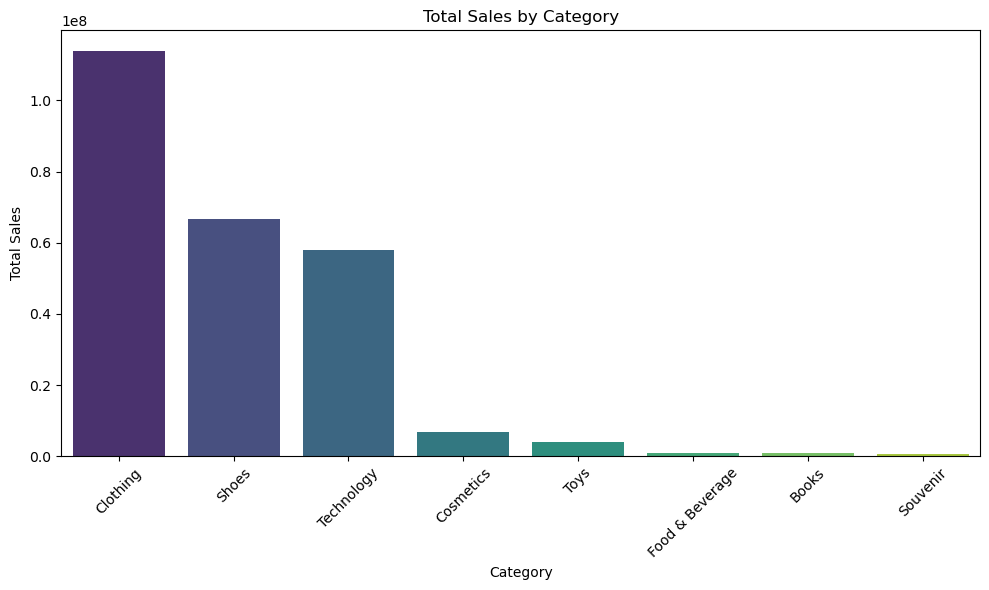

C:\Users\nivetta.t.lv\AppData\Local\Temp\ipykernel_28800\3462533004.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


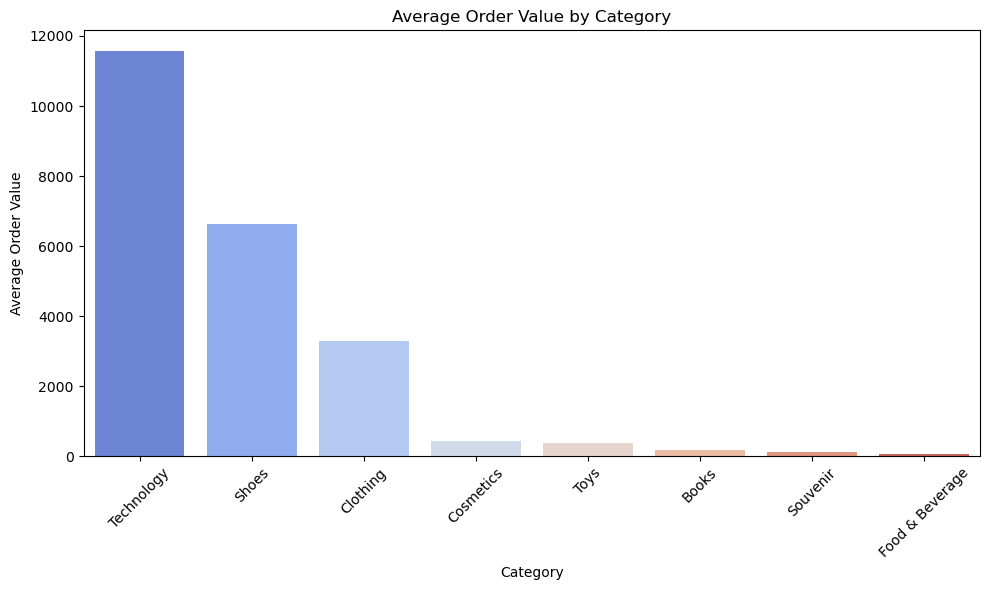

In [54]:
# Category-wise Insights
# --- Step 9: Category-wise Insights ---

# 1. Aggregate by category
category_perf = (
    df.groupby('category')
    .agg(
        total_sales=('net_sales', 'sum'),
        total_qty=('quantity', 'sum'),
        num_customers=('customer_id', 'nunique'),
        num_invoices=('invoice_no', 'nunique')
    )
    .reset_index()
)

# 2. Add average order value (per invoice in that category)
category_perf['avg_order_value'] = category_perf['total_sales'] / category_perf['num_invoices']

print("\nCategory Performance Summary:\n", category_perf.sort_values('total_sales', ascending=False))

# 3. Visualization – Category Sales
plt.figure(figsize=(10,6))
sns.barplot(
    data=category_perf.sort_values('total_sales', ascending=False),
    x='category',
    y='total_sales',
    palette='viridis'
)
plt.title("Total Sales by Category")
plt.xlabel("Category")
plt.ylabel("Total Sales")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 4. Visualization – Category AOV
plt.figure(figsize=(10,6))
sns.barplot(
    data=category_perf.sort_values('avg_order_value', ascending=False),
    x='category',
    y='avg_order_value',
    palette='coolwarm'
)
plt.title("Average Order Value by Category")
plt.xlabel("Category")
plt.ylabel("Average Order Value")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



Category × Segment Performance:
            category    Segment  total_sales  pct_within_category
0             Books    At Risk    343889.85            41.206477
1             Books  Champions     65584.35             7.858621
2             Books       Lost     73704.75             8.831645
3             Books      Loyal    351373.95            42.103257
4          Clothing    At Risk  22056480.16            19.348334
5          Clothing  Champions  35241995.36            30.914901
6          Clothing       Lost    245165.36             0.215063
7          Clothing      Loyal  56453150.16            49.521701
8         Cosmetics    At Risk   2477779.74            36.476222
9         Cosmetics  Champions    804742.72            11.846886
10        Cosmetics       Lost    334916.42             4.930416
11        Cosmetics      Loyal   3175424.02            46.746476
12  Food & Beverage    At Risk    431720.81            50.818481
13  Food & Beverage  Champions     15559.25             

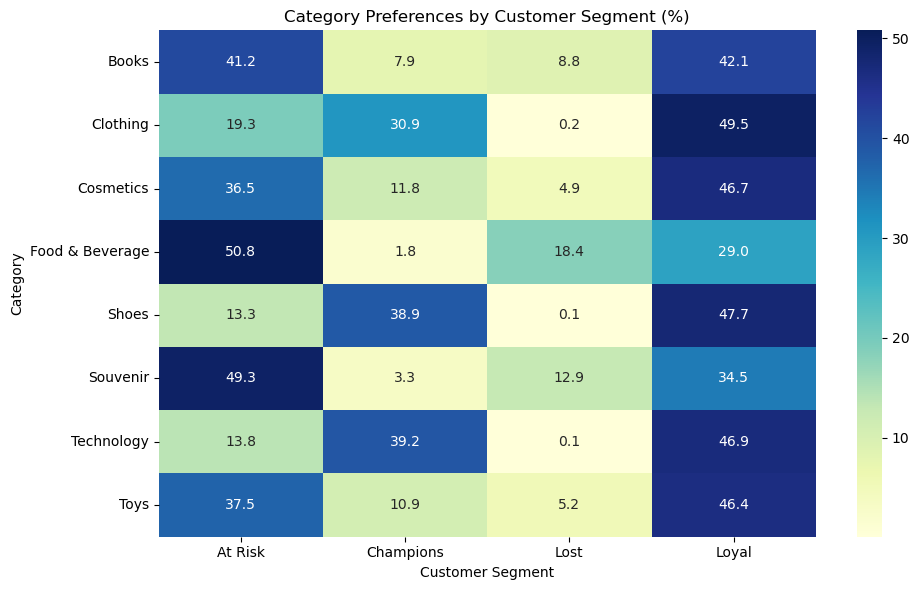

In [55]:
# Category × RFM Segment Insights
# --- Category × RFM Segment Insights ---

# 1. Merge category info with RFM segments
df_with_segments = df.merge(
    rfm[['customer_id', 'Segment']], 
    on='customer_id', 
    how='left'
)

# 2. Aggregate sales by category & segment
cat_segment_perf = (
    df_with_segments.groupby(['category', 'Segment'])
    .agg(total_sales=('net_sales', 'sum'))
    .reset_index()
)

# 3. Normalize within each category (to see share of segment per category)
# Corrected percentage calculation
cat_segment_perf['pct_within_category'] = (
    cat_segment_perf.groupby('category')['total_sales']
    .transform(lambda x: x / x.sum() * 100)
)


print("\nCategory × Segment Performance:\n", cat_segment_perf)

# 4. Visualization – Heatmap
pivot_table = cat_segment_perf.pivot(
    index='category', 
    columns='Segment', 
    values='pct_within_category'
).fillna(0)

plt.figure(figsize=(10,6))
sns.heatmap(pivot_table, annot=True, fmt=".1f", cmap="YlGnBu")
plt.title("Category Preferences by Customer Segment (%)")
plt.xlabel("Customer Segment")
plt.ylabel("Category")
plt.tight_layout()
plt.show()


In [56]:
# Top 3 categories within each segment (by sales)
top_categories = (
    cat_segment_perf
    .sort_values(['Segment', 'total_sales'], ascending=[True, False])
    .groupby('Segment')
    .head(3)
    .reset_index(drop=True)
)

print(top_categories[['Segment', 'category', 'total_sales', 'pct_within_category']])


      Segment    category  total_sales  pct_within_category
0     At Risk    Clothing  22056480.16            19.348334
1     At Risk       Shoes   8870512.60            13.328404
2     At Risk  Technology   7986300.00            13.802239
3   Champions    Clothing  35241995.36            30.914901
4   Champions       Shoes  25888332.95            38.898558
5   Champions  Technology  22686300.00            39.207360
6        Lost   Cosmetics    334916.42             4.930416
7        Lost    Clothing    245165.36             0.215063
8        Lost        Toys    208552.96             5.239463
9       Loyal    Clothing  56453150.16            49.521701
10      Loyal       Shoes  31741790.96            47.693681
11      Loyal  Technology  27154050.00            46.928702


In [57]:
# Pivot into summary view
summary = (
    top_categories
    .groupby('Segment')['category']
    .apply(lambda x: ', '.join(x))
    .reset_index(name='Top Categories')
)

print(summary)


     Segment               Top Categories
0    At Risk  Clothing, Shoes, Technology
1  Champions  Clothing, Shoes, Technology
2       Lost    Cosmetics, Clothing, Toys
3      Loyal  Clothing, Shoes, Technology


In [58]:
# Market Basket Analysis (MBA)
# What products are usually bought together? support cross-selling and promotions
# 1. Create basket (invoice-product matrix)
basket = (
    df.groupby(['invoice_no', 'category'])['quantity']
    .sum()
    .unstack()
    .fillna(0)
)

# Convert quantities >0 to 1 (just presence of product)
basket = basket.applymap(lambda x: 1 if x > 0 else 0)

print(basket.head())


C:\Users\nivetta.t.lv\AppData\Local\Temp\ipykernel_28800\3147923059.py:12: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  basket = basket.applymap(lambda x: 1 if x > 0 else 0)


category    Books  Clothing  Cosmetics  Food & Beverage  Shoes  Souvenir  \
invoice_no                                                                 
I100008         0         1          0                0      0         0   
I100014         0         0          1                0      0         0   
I100015         0         1          0                0      0         0   
I100024         1         0          0                0      0         0   
I100027         0         0          0                0      0         0   

category    Technology  Toys  
invoice_no                    
I100008              0     0  
I100014              0     0  
I100015              0     0  
I100024              0     0  
I100027              1     0  


In [59]:
pip install mlxtend


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [60]:
from mlxtend.frequent_patterns import apriori, association_rules

# 2. Frequent itemsets
frequent_itemsets = apriori(basket, min_support=0.01, use_colnames=True)

print(frequent_itemsets.head())


    support           itemsets
0  0.050082            (Books)
1  0.346753         (Clothing)
2  0.151794        (Cosmetics)
3  0.148567  (Food & Beverage)
4  0.100888            (Shoes)


C:\Users\nivetta.t.lv\AppData\Roaming\Python\Python313\site-packages\mlxtend\frequent_patterns\fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


In [61]:
# 3. Association rules
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.0)
rules = rules.sort_values(by="lift", ascending=False)

print(rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head(10))


Empty DataFrame
Columns: [antecedents, consequents, support, confidence, lift]
Index: []


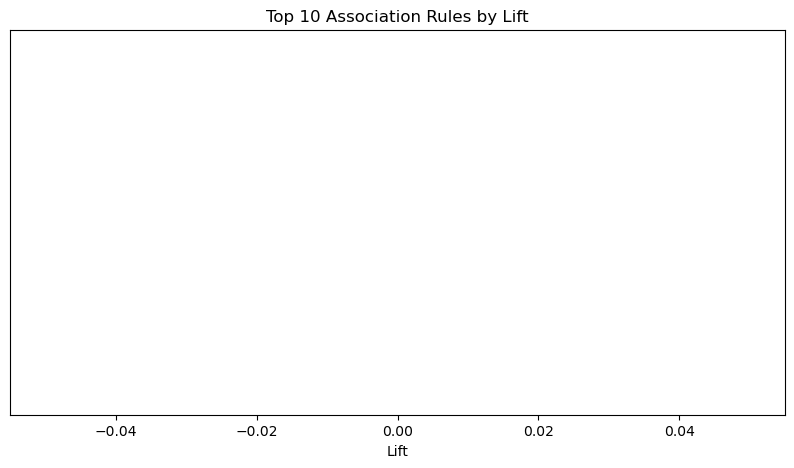

In [63]:
# Ensure 'lift' is numeric
rules['lift'] = pd.to_numeric(rules['lift'], errors='coerce')

# Now safely pick top 10
top_rules = rules.nlargest(10, 'lift')

plt.figure(figsize=(10,5))
plt.barh(range(len(top_rules)), top_rules['lift'], color="skyblue")
plt.yticks(range(len(top_rules)), top_rules['consequents'].astype(str))
plt.xlabel("Lift")
plt.title("Top 10 Association Rules by Lift")
plt.show()


In [64]:
print(rules['lift'].head(20))
print(rules['lift'].dtype)


Series([], Name: lift, dtype: int64)
int64


In [65]:
print(frequent_itemsets.head())
print(frequent_itemsets.shape)


    support           itemsets
0  0.050082            (Books)
1  0.346753         (Clothing)
2  0.151794        (Cosmetics)
3  0.148567  (Food & Beverage)
4  0.100888            (Shoes)
(8, 2)


In [66]:
frequent_itemsets = apriori(
    basket,
    min_support=0.01,   # lower support if needed
    use_colnames=True,
    max_len=2           # allow pairs of items
)

C:\Users\nivetta.t.lv\AppData\Roaming\Python\Python313\site-packages\mlxtend\frequent_patterns\fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


In [67]:
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=0.1)
print(rules.head())
print(rules.shape)

Empty DataFrame
Columns: [antecedents, consequents, antecedent support, consequent support, support, confidence, lift, representativity, leverage, conviction, zhangs_metric, jaccard, certainty, kulczynski]
Index: []
(0, 14)


In [ ]:
# Campaign Simulation
# Model targeting high-value customers with a 10% discount—project ROI.

Baseline revenue (top 10% customers): 123,996,653.09


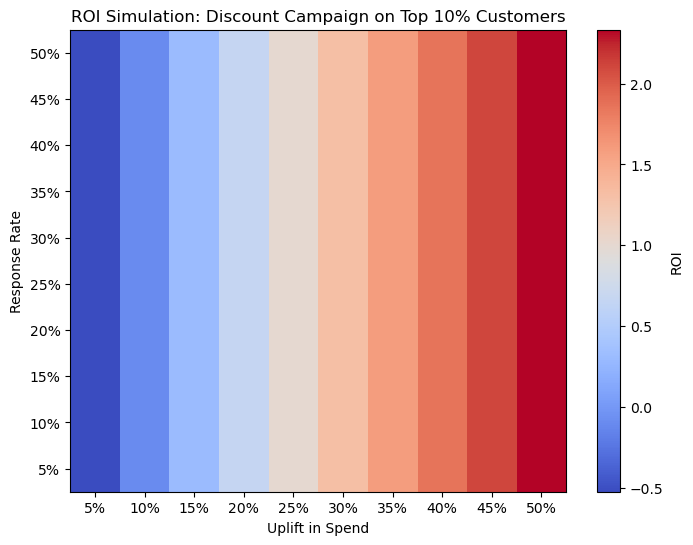

In [69]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ----------------------------
# 1. Baseline: Top 10% Customers
# ----------------------------
# Make sure you already have customer_summary with 'customer_id' and 'total_spent'

# Rank customers by spend
customer_summary = customer_summary.sort_values('total_spent', ascending=False)
top_10_cutoff = int(len(customer_summary) * 0.1)
top_customers = customer_summary.head(top_10_cutoff)

# Baseline revenue from top 10%
B = top_customers['total_spent'].sum()
print(f"Baseline revenue (top 10% customers): {B:,.2f}")

# ----------------------------
# 2. Campaign Parameters
# ----------------------------
discount = 0.10          # 10% discount
N = len(top_customers)   # number of targeted customers

response_rates = np.arange(0.05, 0.55, 0.05)   # 5% → 50%
uplift_levels  = np.arange(0.05, 0.55, 0.05)   # 5% → 50%

# ----------------------------
# 3. ROI Simulation
# ----------------------------
results = []

for R in response_rates:
    for U in uplift_levels:
        # Gains from uplifted spend
        gain = B * R * U
        
        # Discount cost on all responding customers (baseline + uplift)
        cost = (B * R * discount) + (B * R * U * discount)
        
        roi = (gain - cost) / cost if cost > 0 else 0
        results.append([R, U, roi])

results_df = pd.DataFrame(results, columns=['ResponseRate', 'Uplift', 'ROI'])
roi_pivot = results_df.pivot(index='ResponseRate', columns='Uplift', values='ROI')

plt.figure(figsize=(8,6))
plt.title("ROI Simulation: Discount Campaign on Top 10% Customers")
plt.imshow(roi_pivot, cmap="coolwarm", aspect="auto", origin="lower")
plt.colorbar(label="ROI")
plt.xticks(ticks=np.arange(len(uplift_levels)), labels=[f"{u:.0%}" for u in uplift_levels])
plt.yticks(ticks=np.arange(len(response_rates)), labels=[f"{r:.0%}" for r in response_rates])
plt.xlabel("Uplift in Spend")
plt.ylabel("Response Rate")
plt.show()

